### Import Libaray

In [1]:
import MetaTrader5 as mt
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timezone
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

from backtesting import Backtest, Strategy
from backtesting.lib import crossover

from backtesting.test import SMA, GOOG

import warnings 
warnings.filterwarnings("ignore")


c:\Users\User\anaconda3\Lib\site-packages\backtesting\test\__init__.py:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.read_csv(join(dirname(__file__), filename),
c:\Users\User\anaconda3\Lib\site-packages\backtesting\test\__init__.py:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.read_csv(join(dirname(__file__), filename),


### MT5 Initialize

In [2]:
# establish MetaTrader 5 connection to a specified trading account
if not mt.initialize(login=116662489,server="Exness-MT5Trial6",password="muxko9-boptEj"):
    print("initialize() failed, error code =",mt.last_error())
    quit()

# display data on connection status, server name and trading account
print(mt.terminal_info())

TerminalInfo(community_account=False, community_connection=False, connected=True, dlls_allowed=False, trade_allowed=False, tradeapi_disabled=False, email_enabled=False, ftp_enabled=False, notifications_enabled=False, mqid=False, build=4361, maxbars=100000, codepage=0, ping_last=33391, community_balance=0.0, retransmission=0.978713859013258, company='Exness Technologies Ltd', name='MetaTrader 5 EXNESS', language='English', path='C:\\Program Files\\MetaTrader 5 EXNESS', data_path='C:\\Users\\User\\AppData\\Roaming\\MetaQuotes\\Terminal\\53785E099C927DB68A545C249CDBCE06', commondata_path='C:\\Users\\User\\AppData\\Roaming\\MetaQuotes\\Terminal\\Common')


### Import data from MT5

In [197]:
symbol = "XAUUSDm" #gold
timeframe = mt.TIMEFRAME_M5 #5 minutes
utc_from = pd.Timestamp('2024-05-09') #start date
utc_to = pd.Timestamp.now() 

### Import to DataFrame

In [198]:
# Retrieve the data
rates = mt.copy_rates_range(symbol, timeframe, utc_from, utc_to)
df = pd.DataFrame(rates)
df

,time,open,high,low,close,tick_volume,spread,real_volume
0,1715212800,2308.733,2309.190,2308.125,2309.022,438,200,0
1,1715213100,2309.073,2309.170,2308.115,2308.257,351,200,0
2,1715213400,2308.219,2308.304,2307.851,2307.947,261,199,0
3,1715213700,2308.002,2308.386,2307.762,2308.179,241,200,0
4,1715214000,2308.209,2308.209,2307.815,2307.930,204,200,0
...,...,...,...,...,...,...,...,...
5660,1717689000,2377.442,2377.773,2375.865,2376.327,619,200,0
5661,1717689300,2376.281,2376.944,2374.063,2374.226,706,199,0
5662,1717689600,2374.209,2375.810,2372.505,2372.956,809,199,0
5663,1717689900,2372.986,2374.389,2372.647,2373.501,615,199,0


In [199]:
df.head()

,time,open,high,low,close,tick_volume,spread,real_volume
0,1715212800,2308.733,2309.190,2308.125,2309.022,438,200,0
1,1715213100,2309.073,2309.170,2308.115,2308.257,351,200,0
2,1715213400,2308.219,2308.304,2307.851,2307.947,261,199,0
3,1715213700,2308.002,2308.386,2307.762,2308.179,241,200,0
4,1715214000,2308.209,2308.209,2307.815,2307.930,204,200,0


In [200]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5665 entries, 0 to 5664
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   time         5665 non-null   int64  
 1   open         5665 non-null   float64
 2   high         5665 non-null   float64
 3   low          5665 non-null   float64
 4   close        5665 non-null   float64
 5   tick_volume  5665 non-null   uint64 
 6   spread       5665 non-null   int32  
 7   real_volume  5665 non-null   uint64 
dtypes: float64(4), int32(1), int64(1), uint64(2)
memory usage: 332.1 KB


In [201]:
df.rename(columns={'time':'Date','open':'Open','high':'High','low':'Low','close':'Close'},inplace=True)
df = df.drop(['tick_volume', 'spread','real_volume'],axis=1)

In [202]:
df.head() # cehck the data after renaming

,Date,Open,High,Low,Close
0,1715212800,2308.733,2309.190,2308.125,2309.022
1,1715213100,2309.073,2309.170,2308.115,2308.257
2,1715213400,2308.219,2308.304,2307.851,2307.947
3,1715213700,2308.002,2308.386,2307.762,2308.179
4,1715214000,2308.209,2308.209,2307.815,2307.930


In [203]:
df.info() # Check data information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5665 entries, 0 to 5664
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5665 non-null   int64  
 1   Open    5665 non-null   float64
 2   High    5665 non-null   float64
 3   Low     5665 non-null   float64
 4   Close   5665 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 221.4 KB


In [204]:
df.describe()

,Date,Open,High,Low,Close
count,5.665000e+03,5665.000000,5665.000000,5665.000000,5665.000000
mean,1.716480e+09,2360.715898,2361.602304,2359.816015,2360.724732
std,7.300425e+05,31.139657,31.220933,31.034632,31.128110
min,1.715213e+09,2307.469000,2308.109000,2306.455000,2307.497000
25%,1.715829e+09,2338.556000,2339.298000,2337.721000,2338.552000
50%,1.716445e+09,2351.978000,2352.733000,2351.198000,2351.951000
75%,1.717074e+09,2377.664000,2378.385000,2377.113000,2377.706000
max,1.717690e+09,2449.859000,2450.025000,2447.692000,2449.823000


In [205]:
df['Date'] = pd.to_datetime(df['Date'], unit='s')
df = df.rename(columns={'Date': 'Date/Time'})
df.set_index('Date/Time', inplace=True)
# df.reset_index(inplace=True)

In [206]:
# Display the first few rows of the DataFrame
df.head()

,Open,High,Low,Close
Date/Time,,,,
2024-05-09 00:00:00,2308.733,2309.190,2308.125,2309.022
2024-05-09 00:05:00,2309.073,2309.170,2308.115,2308.257
2024-05-09 00:10:00,2308.219,2308.304,2307.851,2307.947
2024-05-09 00:15:00,2308.002,2308.386,2307.762,2308.179
2024-05-09 00:20:00,2308.209,2308.209,2307.815,2307.930


In [207]:
df.tail()

,Open,High,Low,Close
Date/Time,,,,
2024-06-06 15:50:00,2377.442,2377.773,2375.865,2376.327
2024-06-06 15:55:00,2376.281,2376.944,2374.063,2374.226
2024-06-06 16:00:00,2374.209,2375.810,2372.505,2372.956
2024-06-06 16:05:00,2372.986,2374.389,2372.647,2373.501
2024-06-06 16:10:00,2373.550,2374.150,2373.062,2374.150


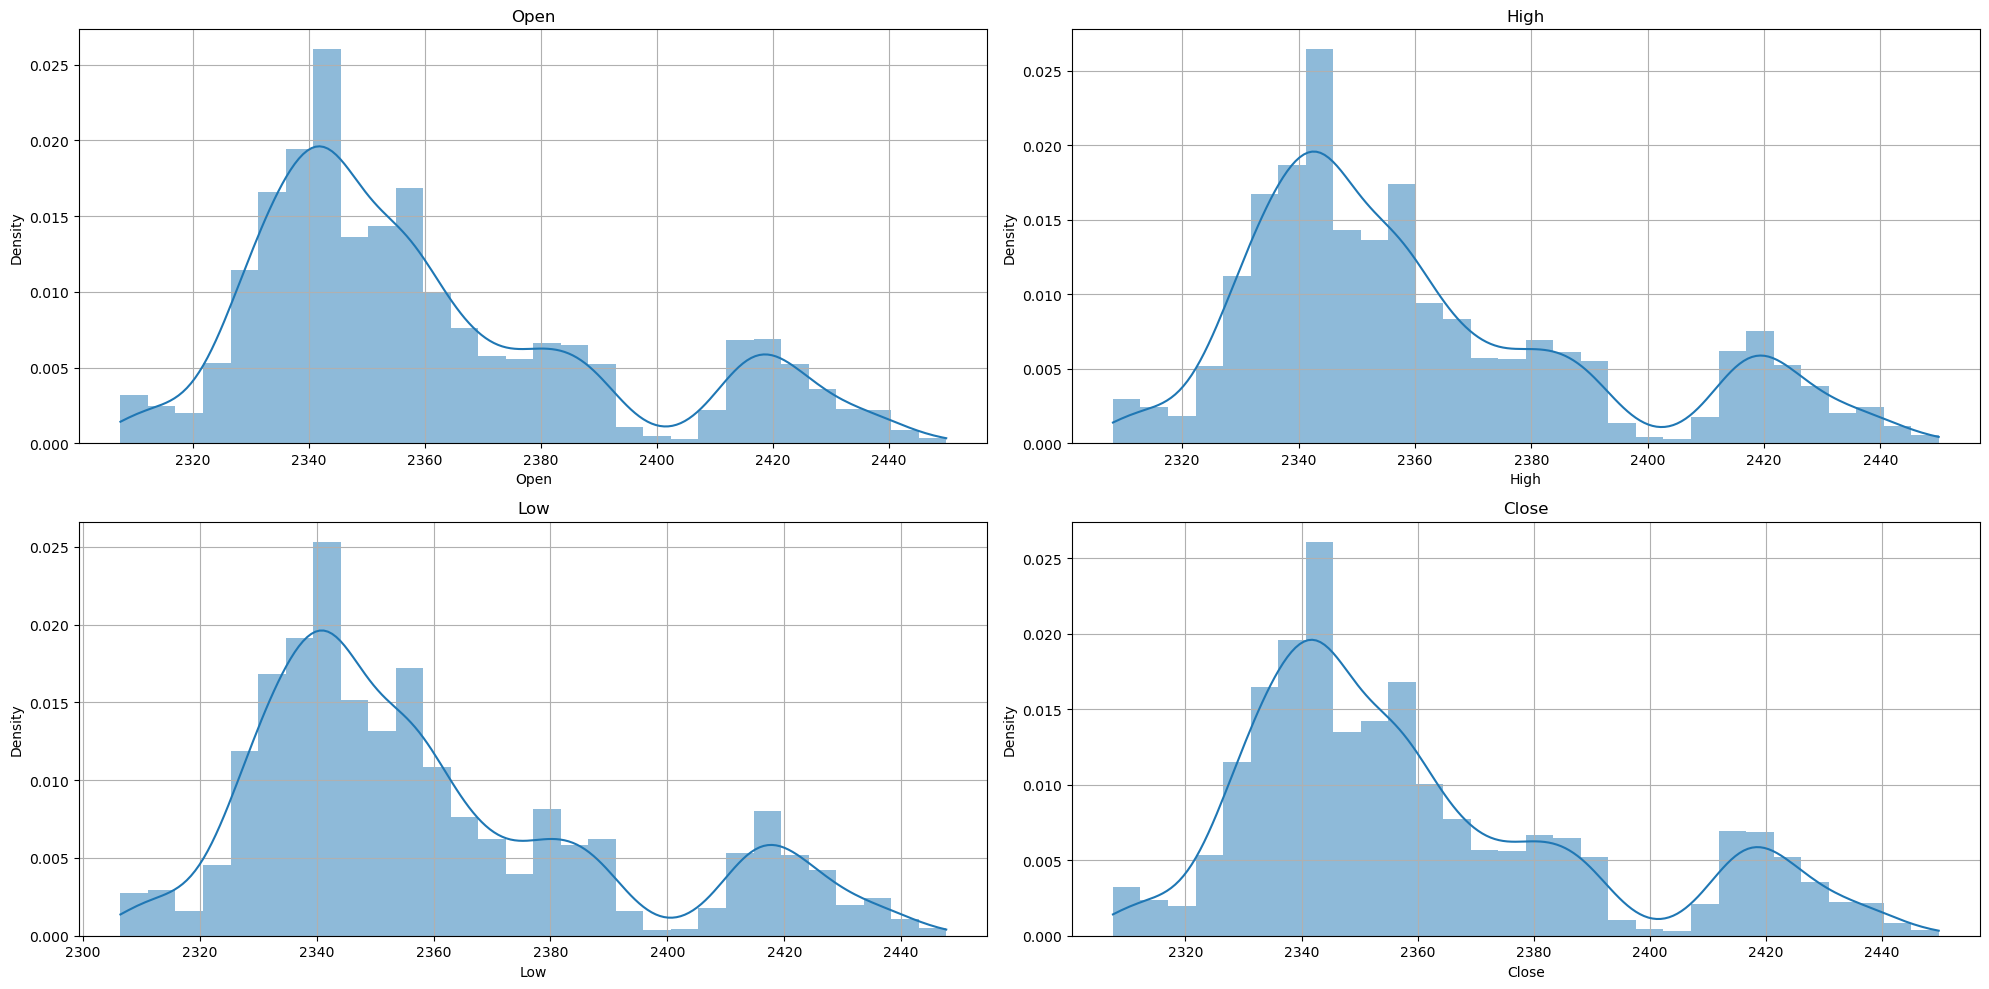

In [208]:
features = ['Open', 'High', 'Low', 'Close'] 

fig, axs = plt.subplots(2, 2, figsize=(20,10))

for i, col in enumerate(features): 
  ax = plt.subplot(2, 2, i+1)
  sns.histplot(df[col], label="100% Equities", kde=True, stat="density", linewidth=0, ax=ax, bins=30) 
  ax.set_title(col)
  ax.set_xlabel(col)
  ax.set_ylabel('Density')
  ax.grid()

plt.tight_layout()
plt.show()

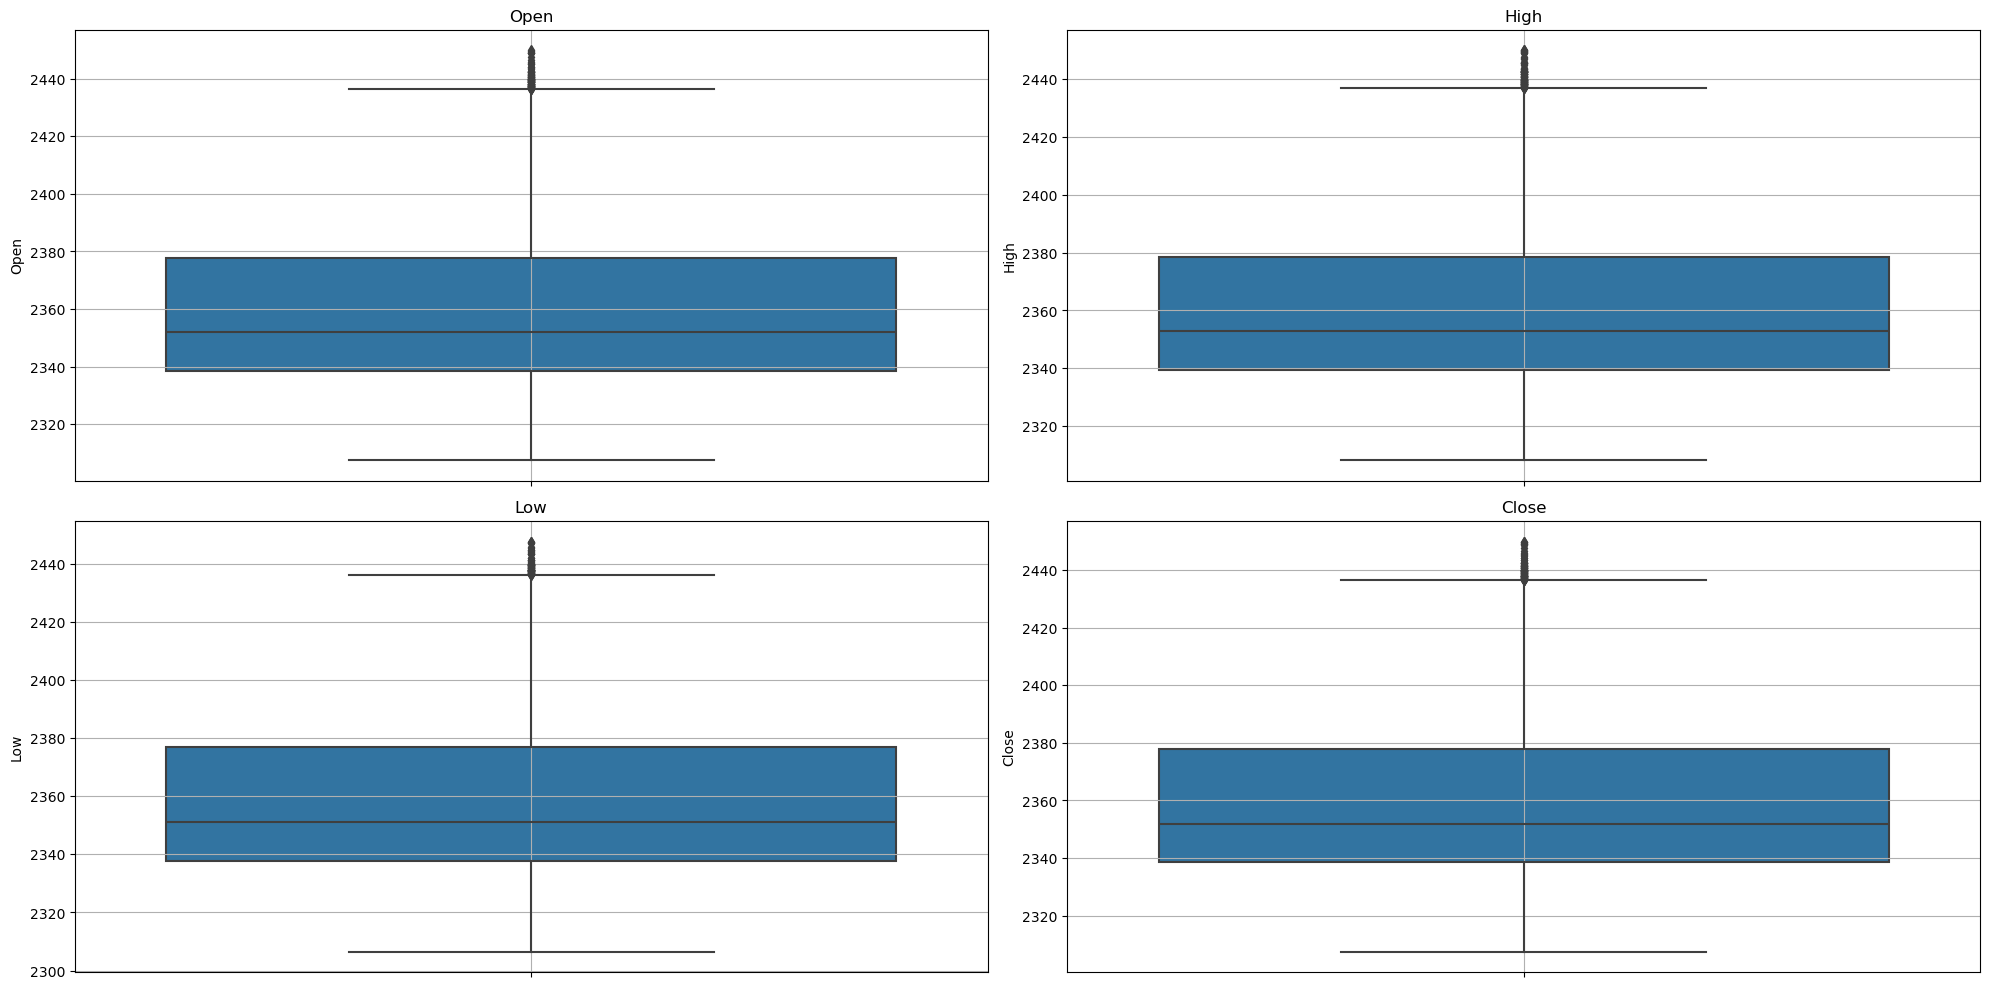

In [209]:
features = ['Open', 'High', 'Low', 'Close'] 

fig, axs = plt.subplots(2, 2, figsize=(20,10))

for i, col in enumerate(features): 
  ax = plt.subplot(2, 2, i+1)
  sns.boxplot(y=df[col], ax=ax) 
  ax.set_title(col)
  ax.set_xlabel('')
  ax.set_ylabel(col)
  ax.grid()

plt.tight_layout()
plt.show()

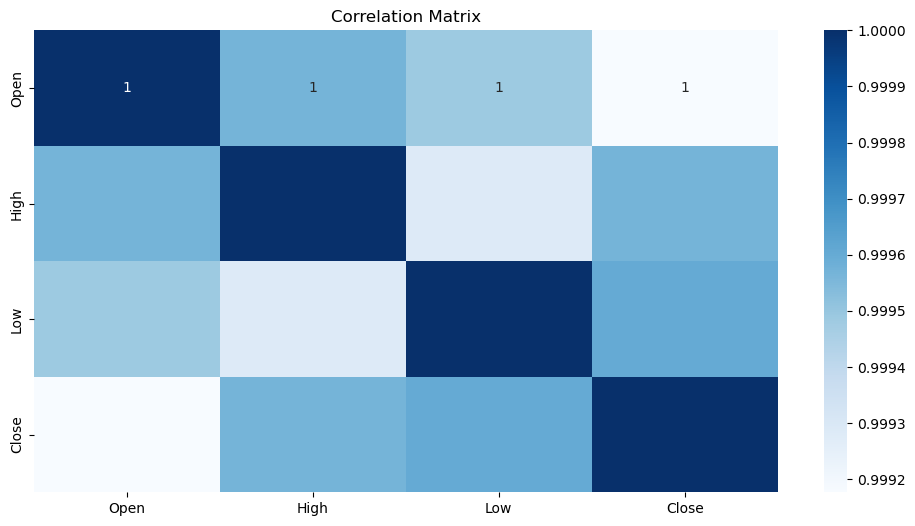

In [211]:
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(), annot=True, cmap='Blues')
plt.title('Correlation Matrix')
plt.show()


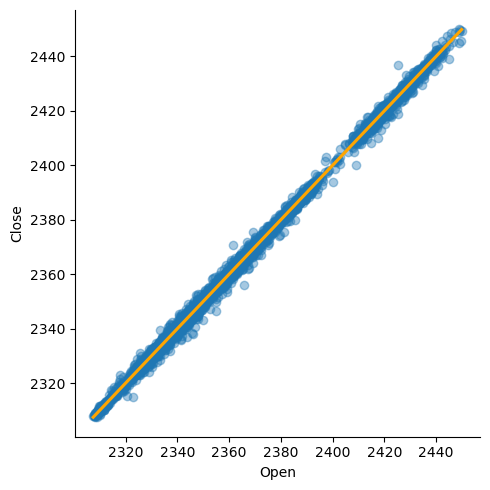

In [212]:
sns.lmplot(x='Open', y='Close', data=df, ci=None,
           scatter_kws={'alpha':0.4},
           line_kws={'color':'orange'})

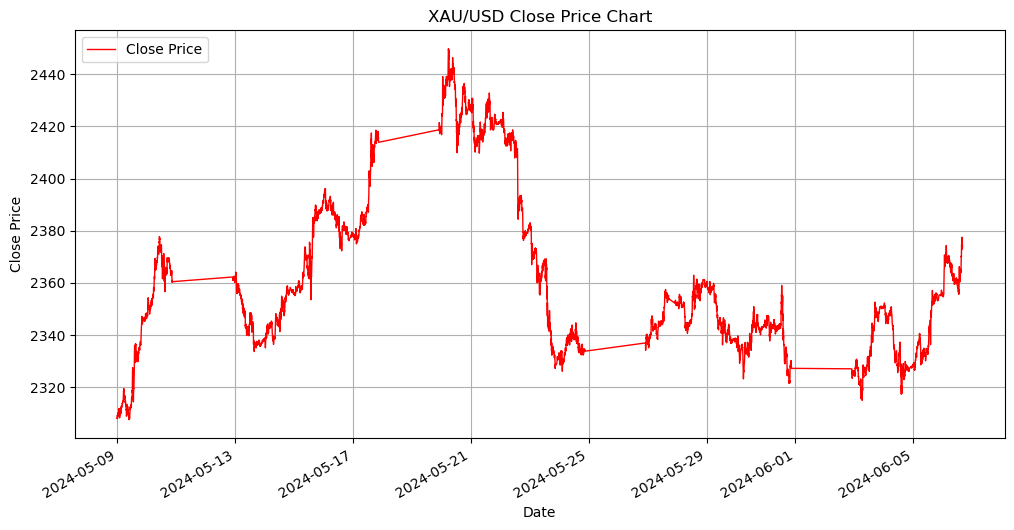

In [213]:
df_plot = df['Close'].plot(figsize=(12, 6), 
                           title='XAU/USD Close Price Chart', 
                           grid=True, 
                           color='red', 
                           label='Close Price',
                           lw=1)
df_plot.set_xlabel('Date')
df_plot.set_ylabel('Close Price')
df_plot.legend(loc='upper left')
plt.show()

In [214]:
df.duplicated().sum()

0

In [215]:
df.isnull().sum().sum()

0

In [216]:
# # get all data today for testing
# # Define the specific date
# specific_date = pd.Timestamp.today().normalize()
# print('Today(date-time):',specific_date)
# # Select the rows for the specific date
# df_specific_date = df[df.index.date == specific_date.date()]
# test_size = df_specific_date.shape[0]
# # Print the DataFrame for the specific date
# print('Test_size:',test_size)
# df_specific_date.head()


# get all data for the current month for testing
# Define the current month
current_month = pd.Timestamp.today().normalize().month
print('Current Month:', current_month)

# Select the rows for the current month
df_current_month = df[df.index.month == current_month]
test_size = df_current_month.shape[0]

# Print the DataFrame for the current month
print('Test_size:', test_size)
df_current_month.head()

Current Month: 6
Test_size: 1046


,Open,High,Low,Close
Date/Time,,,,
2024-06-02 22:05:00,2328.496,2328.760,2326.583,2327.009
2024-06-02 22:10:00,2327.043,2327.104,2324.172,2325.173
2024-06-02 22:15:00,2325.144,2326.622,2325.076,2325.931
2024-06-02 22:20:00,2325.932,2325.950,2324.535,2325.247
2024-06-02 22:25:00,2325.243,2325.243,2323.340,2323.340


In [218]:
# Define features
features = ['Open', 'High', 'Low', 'Close']
# Define window size
window_size = 25

# Initialize the MinMaxScaler for each feature
scalers = {feature: MinMaxScaler() for feature in features}

# Scale the data
scaled_data = {feature: scalers[feature].fit_transform(df[feature].values.reshape(-1, 1)) for feature in features}

# Split the data into training and testing sets
train_data = {feature: scaled_data[feature][:-test_size - window_size] for feature in features}
test_data = {feature: scaled_data[feature][-test_size - window_size:] for feature in features}
# Function to create sequences for training and testing
def create_sequences(data, window_size):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Create sequences for training and testing
X_train = {feature: [] for feature in features}
y_train = {feature: [] for feature in features}
X_test = {feature: [] for feature in features}
y_test = {feature: [] for feature in features}

for feature in features:
    X_train[feature], y_train[feature] = create_sequences(train_data[feature], window_size)
    X_test[feature], y_test[feature] = create_sequences(test_data[feature], window_size)

# Print the shapes of the training and testing data for each feature
for feature in features:
    print(f"{feature} - X_train shape: {X_train[feature].shape}, y_train shape: {y_train[feature].shape}")
    print(f"{feature} - X_test shape: {X_test[feature].shape}, y_test shape: {y_test[feature].shape}")
    print("-"*30)


Open - X_train shape: (4569, 25), y_train shape: (4569,)
Open - X_test shape: (1046, 25), y_test shape: (1046,)
------------------------------
High - X_train shape: (4569, 25), y_train shape: (4569,)
High - X_test shape: (1046, 25), y_test shape: (1046,)
------------------------------
Low - X_train shape: (4569, 25), y_train shape: (4569,)
Low - X_test shape: (1046, 25), y_test shape: (1046,)
------------------------------
Close - X_train shape: (4569, 25), y_train shape: (4569,)
Close - X_test shape: (1046, 25), y_test shape: (1046,)
------------------------------


In [219]:
# Initialize empty DataFrames for actual and predicted values
df_actual = pd.DataFrame(index=df.index[-test_size-window_size:-window_size])
df_pred = pd.DataFrame(index=df.index[-test_size-window_size:-window_size])

# Loop through each feature
for feature in features:
    # Train the model
    model = LinearRegression()
    model.fit(X_train[feature], y_train[feature])
    
    # Make predictions
    y_pred = model.predict(X_test[feature])
    
    # Create DataFrames for actual and predicted values for the current feature
    df_actual_feature = pd.DataFrame({f'{feature}': y_test[feature]}, index=df.index[-test_size-window_size:-window_size])
    df_pred_feature = pd.DataFrame({f'{feature}': y_pred}, index=df.index[-test_size-window_size:-window_size])
    
    # Concatenate the DataFrames for the current feature with the overall DataFrames
    df_actual = pd.concat([df_actual, df_actual_feature], axis=1)
    df_pred = pd.concat([df_pred, df_pred_feature], axis=1)


In [220]:
df_actual.head()

,Open,High,Low,Close
Date/Time,,,,
2024-05-31 18:55:00,0.147672,0.145516,0.142512,0.137094
2024-05-31 19:00:00,0.137468,0.133847,0.125442,0.124194
2024-05-31 19:05:00,0.124131,0.130450,0.131842,0.129520
2024-05-31 19:10:00,0.129665,0.125715,0.128012,0.124714
2024-05-31 19:15:00,0.124826,0.120733,0.119551,0.111315


In [221]:
df_pred.head()

,Open,High,Low,Close
Date/Time,,,,
2024-05-31 18:55:00,0.142033,0.140825,0.147757,0.137964
2024-05-31 19:00:00,0.147025,0.146448,0.142033,0.138731
2024-05-31 19:05:00,0.139654,0.133119,0.124464,0.124477
2024-05-31 19:10:00,0.124505,0.129224,0.133468,0.129502
2024-05-31 19:15:00,0.129384,0.125961,0.126796,0.124442


In [222]:
metrics = []
# Train and evaluate a separate model for each feature
for feature in features:
 
    # Calculate the metrics
    mae = mean_absolute_error(y_test[feature], y_pred)
    mse = mean_squared_error(y_test[feature], y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test[feature], y_pred)
    # Append the metrics to the list
    metrics.append([feature, mae, mse, rmse, r2, r2 * 100])

# Convert the metrics list to a DataFrame
metrics_df = pd.DataFrame(metrics, columns=['Feature', 'MAE', 'MSE', 'RMSE', 'R2', 'R2 (%)'])
metrics_df.head()

,Feature,MAE,MSE,RMSE,R2,R2 (%)
0,Open,0.000621,9.223749e-07,0.000960,0.999914,99.991365
1,High,0.004278,4.822326e-05,0.006944,0.995524,99.552424
2,Low,0.005659,4.813999e-05,0.006938,0.995582,99.558240
3,Close,0.005691,6.871784e-05,0.008290,0.993598,99.359811


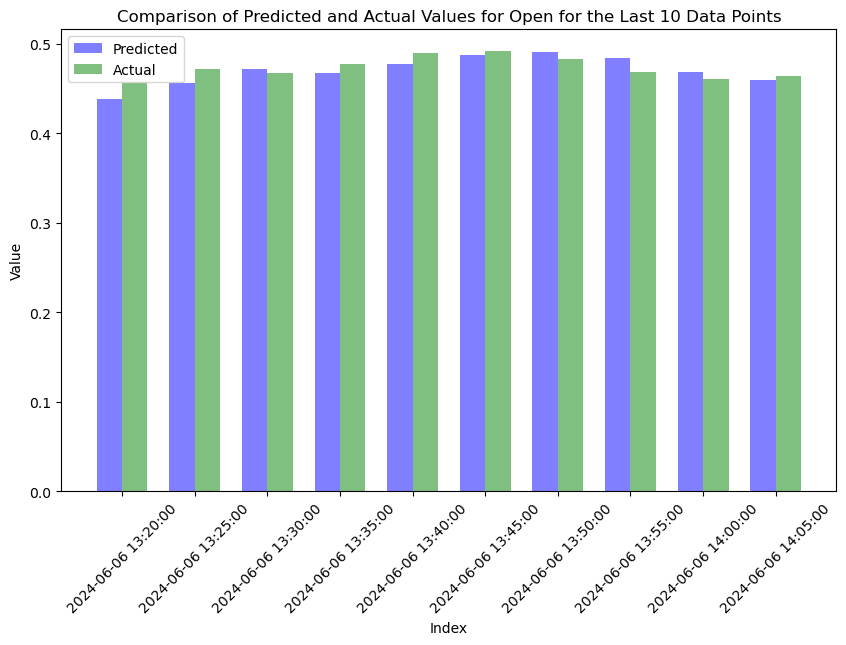

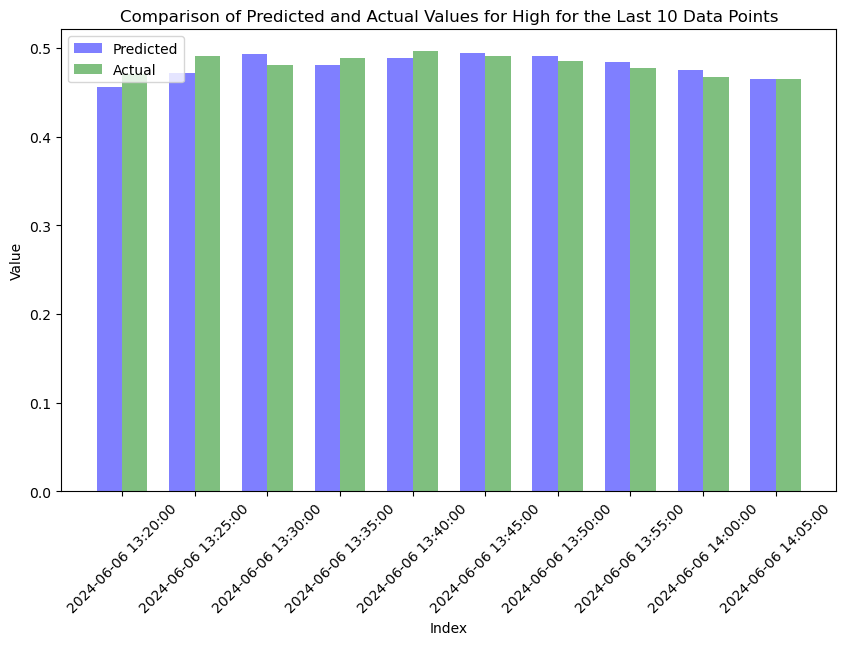

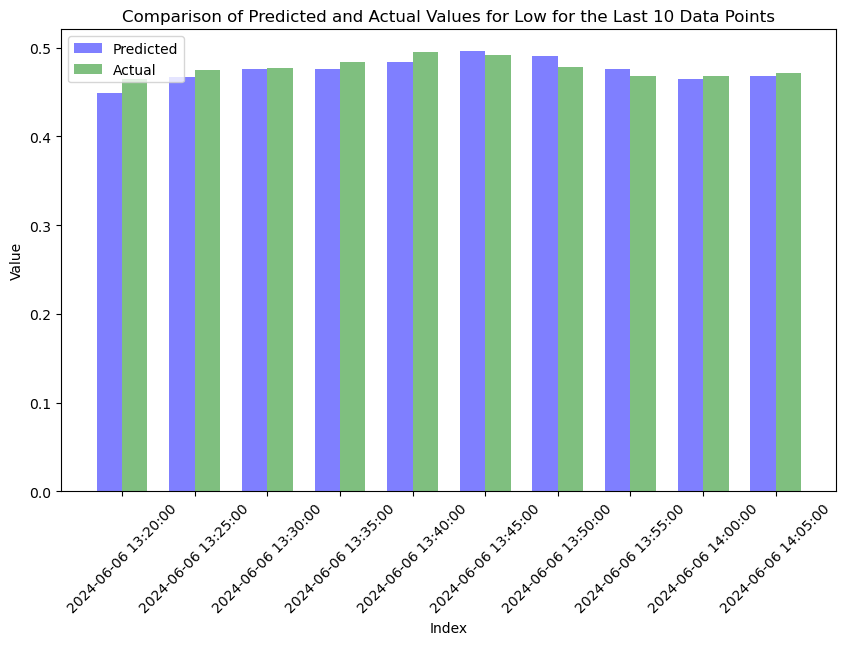

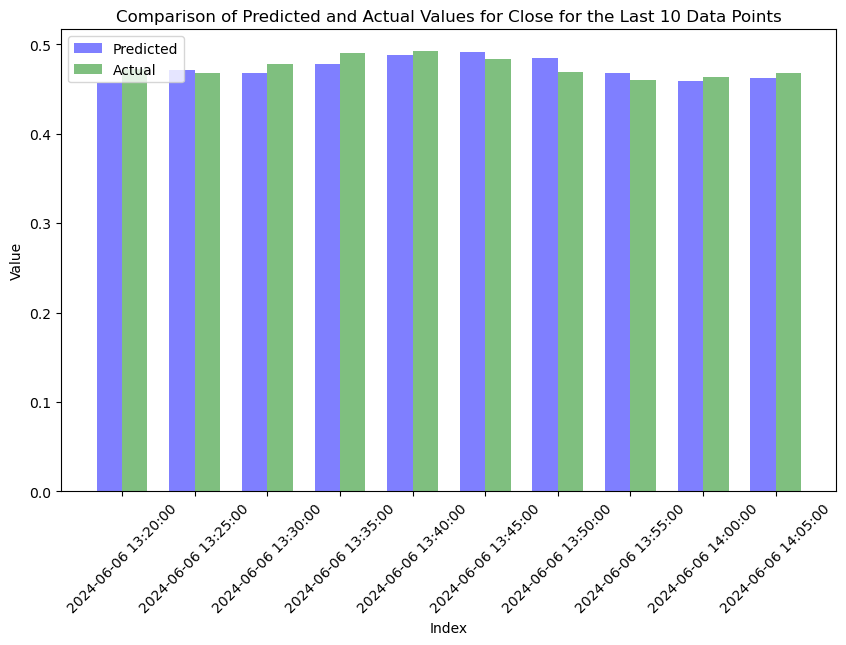

In [224]:
import numpy as np

# Get the indices
indices = df_pred.index[-10:]  # Select the last 10 indices

# Define the width of the bars
bar_width = 0.35

# Create an array of indices for positioning the bars
x = np.arange(len(indices))

# Iterate over each feature
for feature in features:
    # Set the figure size
    plt.figure(figsize=(10, 6))

    # Plot the predicted values
    plt.bar(x - bar_width/2, df_pred[feature][-10:], color='blue', width=bar_width, alpha=0.5, label='Predicted')

    # Plot the actual values
    plt.bar(x + bar_width/2, df_actual[feature][-10:], color='green', width=bar_width, alpha=0.5, label='Actual')

    # Set the x-axis ticks and labels
    plt.xticks(x, indices, rotation=45)  # Rotate the x-labels by 45 degrees

    # Set the x-axis label
    plt.xlabel('Index')

    # Set the y-axis label
    plt.ylabel('Value')

    # Set the title
    plt.title(f'Comparison of Predicted and Actual Values for {feature} for the Last 10 Data Points')

    # Set the legend
    plt.legend()

    # Show the plot
    plt.show()


In [227]:
class MyStrategy(Strategy):
    stop_loss = 0.02  # 2% stop loss    
    def init(self):
        # Define the indicators you want to use
        self.ma1 = self.I(SMA, self.data.Close, 10)
        self.ma2 = self.I(SMA, self.data.Close, 20)

    def next(self):
        # If the fast MA crosses above the slow MA, buy the asset
        if crossover(self.ma1, self.ma2):
            self.buy()

        # If the fast MA crosses below the slow MA, sell the asset and set a stop loss
        elif crossover(self.ma2, self.ma1):
            self.sell(sl=self.data.Close[-1] * (1 + self.stop_loss))  # stop loss

# Get your data
data = df_pred

# Initialize the backtest
bt = Backtest(data, MyStrategy, cash=10000)
bt.run()
bt.plot()
# Run the backtest
output = bt.run()

# Print the output
print(output)

Start                     2024-05-31 18:55:00
End                       2024-06-06 14:05:00
Duration                      5 days 19:10:00
Exposure Time [%]                    97.89675
Equity Final [$]                 35086.275747
Equity Peak [$]                  37549.764206
Return [%]                         250.862757
Buy & Hold Return [%]              234.872479
Return (Ann.) [%]         6696001410593633...
Volatility (Ann.) [%]     2490697209068730...
Sharpe Ratio                              0.0
Sortino Ratio             2251425028927899...
Calmar Ratio              8511260341138038...
Max. Drawdown [%]                  -78.672266
Avg. Drawdown [%]                  -12.078985
Max. Drawdown Duration        2 days 01:50:00
Avg. Drawdown Duration        0 days 05:25:00
# Trades                                    1
Win Rate [%]                            100.0
Best Trade [%]                      250.86317
Worst Trade [%]                     250.86317
Avg. Trade [%]                    